El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos

In [91]:
#importacion de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
%config InlineBackend.figure_format = 'retina'

import warnings

warnings.filterwarnings('ignore')

In [2]:
#carga de datos
data = pd.read_csv("/datasets/car_data.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [5]:
data.duplicated().sum()

262

In [6]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Se tiene con un DataFrame que contiene 354369 registros, 16 columnas:
1. Hay 5 columnas con datos ausentes (vehicleType, Gearbox, Model, Fuel_type, NotRepaired)
2. El nombre de las columnas estan en mayúsculas y sin separadores.
3. 262 datos duplicados
4. Fechas sin formatos de fecha

In [7]:
#cambio en los nombres de columnas
columns = []
for name in data.columns.values:
    name = re.sub("([A-Z])", r' \1', name).lower().replace(' ', '_')[1:]
    columns.append(name)
data.columns = columns

In [8]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

In [9]:
#revisión de las columnas
data["vehicle_type"].value_counts(normalize=True)

sedan          0.288618
small          0.251929
wagon          0.205649
bus            0.090808
convertible    0.063756
coupe          0.051007
suv            0.037857
other          0.010376
Name: vehicle_type, dtype: float64

In [10]:
#calculo de porcentaje de ausentes en las columnas
def porcentaje_ausentes(data, columna):
    data_or_ausentes = data[columna].count()
    data_total_orig = data[columna].size
    porcentaje_ausentes = (data_total_orig - data_or_ausentes)/data_total_orig
    print(f"Porcentaje de datos ausentes en el campo {columna} en la data original:{porcentaje_ausentes:.0%}")

porcentaje_ausentes(data,"vehicle_type")

Porcentaje de datos ausentes en el campo vehicle_type en la data original:11%


In [11]:
data[(data["vehicle_type"].isna()) & (data["model"].isna())]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
260,04/04/2016 09:49,450,NaN,2016,manual,0,NaN,150000,3,petrol,mitsubishi,no,04/04/2016 00:00,0,59302,06/04/2016 11:17
306,21/03/2016 14:38,200,NaN,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,21/03/2016 00:00,0,6493,24/03/2016 02:47
435,27/03/2016 18:43,1300,NaN,2017,manual,150,NaN,150000,10,NaN,volkswagen,no,27/03/2016 00:00,0,70374,05/04/2016 15:15
443,24/03/2016 16:46,1950,NaN,2017,manual,0,NaN,150000,7,petrol,volkswagen,no,24/03/2016 00:00,0,70376,30/03/2016 18:16
478,24/03/2016 17:49,0,NaN,2000,manual,0,NaN,150000,0,NaN,audi,yes,24/03/2016 00:00,0,72514,29/03/2016 03:45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354083,30/03/2016 07:54,0,NaN,2000,NaN,0,NaN,150000,0,NaN,sonstige_autos,NaN,30/03/2016 00:00,0,6686,06/04/2016 23:46
354162,07/03/2016 19:51,1500,NaN,1995,NaN,0,NaN,150000,0,NaN,volkswagen,NaN,07/03/2016 00:00,0,26789,03/04/2016 11:46
354338,31/03/2016 19:52,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,31/03/2016 00:00,0,41470,06/04/2016 14:18
354351,11/03/2016 23:40,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,11/03/2016 00:00,0,87700,12/03/2016 14:16


La columna "vehicle_type" contiene 11% de datos ausentes. El tipo de vehículo que más se pública es el sedan con 29%, seguido por small y wagon con 25% y 21% respectivamente. Dentro de la clasificación se encuentra "other" en el cual se podría agrupar los datos ausentes, por lo que se imputarán con "other".

In [12]:
data["vehicle_type"].fillna("other", inplace=True)
data["vehicle_type"].isna().sum()

0

In [13]:
data["gearbox"].value_counts(normalize=True)

manual    0.80186
auto      0.19814
Name: gearbox, dtype: float64

In [14]:
porcentaje_ausentes(data,"gearbox")

Porcentaje de datos ausentes en el campo gearbox en la data original:6%


Se aprecia que el 80% de los vehiclulo en venta tienen una caja de cambios manual y el resto automática. Esta columna categórica que tiene un 6% de datos ausentes, puede ser imputada con "sin especificar"

In [15]:
data["gearbox"].fillna("sin especificar", inplace=True)
data["gearbox"].isna().sum()

0

In [16]:
data["model"].value_counts(normalize=True)

golf                  0.087347
other                 0.072972
3er                   0.059047
polo                  0.039042
corsa                 0.037560
                        ...   
i3                    0.000024
rangerover            0.000012
serie_3               0.000012
serie_1               0.000006
range_rover_evoque    0.000006
Name: model, Length: 250, dtype: float64

In [17]:
porcentaje_ausentes(data,"model")

Porcentaje de datos ausentes en el campo model en la data original:6%


En esta columna los porcentajes están distribuidos entre un gran número de modelos, siendo el golf el mas popular con 9%. La imputación se realizará con "sin especificar " para el 6% de datos ausentes.

In [18]:
data["model"].fillna("sin especificar", inplace=True)
data["model"].isna().sum()

0

In [19]:
data["fuel_type"].value_counts(normalize=True)

petrol      0.673000
gasoline    0.307085
lpg         0.016518
cng         0.001758
hybrid      0.000725
other       0.000635
electric    0.000280
Name: fuel_type, dtype: float64

In [20]:
porcentaje_ausentes(data,"fuel_type")

Porcentaje de datos ausentes en el campo fuel_type en la data original:9%


El 67% de los autos publicados usan petrol como combustible, un 0.6% entra en la categoría otros. La imputación se realizará con "other" para el 9% de los datos ausentes.

In [21]:
data["fuel_type"].fillna("other", inplace=True)
data["fuel_type"].isna().sum()

0

In [22]:
data["not_repaired"].value_counts(normalize=True)

no     0.872697
yes    0.127303
Name: not_repaired, dtype: float64

In [23]:
porcentaje_ausentes(data,"not_repaired")


Porcentaje de datos ausentes en el campo not_repaired en la data original:20%


In [24]:
data.query('not_repaired.isna()')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
8,04/04/2016 23:42,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,04/04/2016 00:00,0,94505,04/04/2016 23:42
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,other,volkswagen,NaN,17/03/2016 00:00,0,27472,31/03/2016 17:17
12,15/03/2016 22:49,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN,15/03/2016 00:00,0,37269,01/04/2016 13:16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354349,16/03/2016 17:06,5999,wagon,2005,manual,140,a4,150000,4,gasoline,audi,NaN,16/03/2016 00:00,0,56472,18/03/2016 11:30
354356,04/04/2016 11:45,999,convertible,2000,manual,95,megane,150000,4,petrol,renault,NaN,04/04/2016 00:00,0,88477,06/04/2016 12:44
354357,09/03/2016 11:36,1690,wagon,2004,manual,55,fabia,150000,4,petrol,skoda,NaN,09/03/2016 00:00,0,18246,04/04/2016 08:15
354365,14/03/2016 17:48,2200,other,2005,sin especificar,0,sin especificar,20000,1,other,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46


La columna "not_repaired" contiene datos categóricos y el 87% de la data corresponde a que no ha sido reparado, sin embargo, la imputación se realizará completando el campo con: "sin especificar".

In [25]:
data["not_repaired"].fillna("sin especificar", inplace=True)
data["not_repaired"].value_counts()

no                 247161
sin especificar     71154
yes                 36054
Name: not_repaired, dtype: int64

In [26]:
data.describe()

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


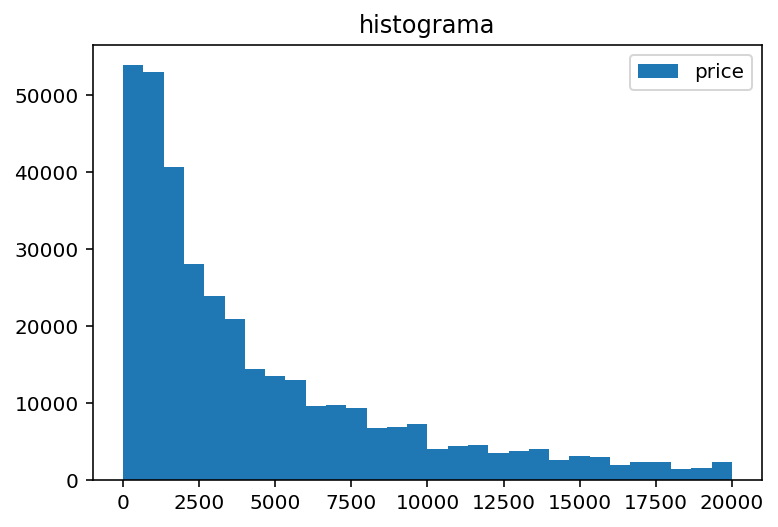

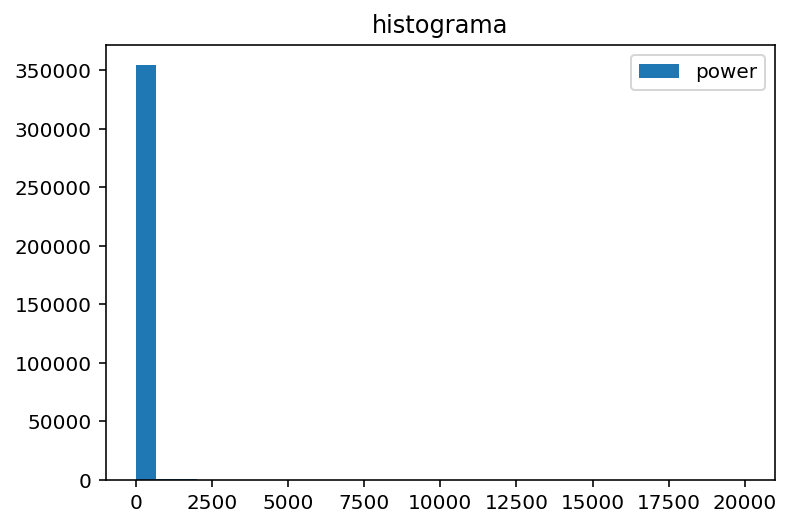

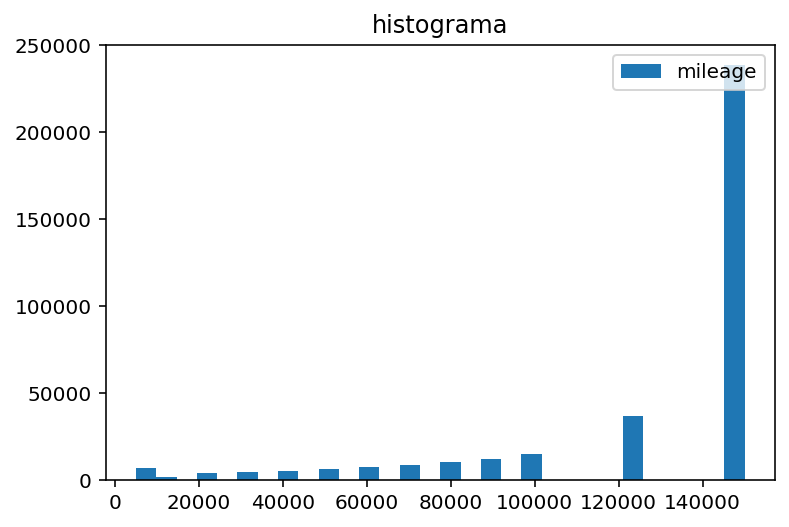

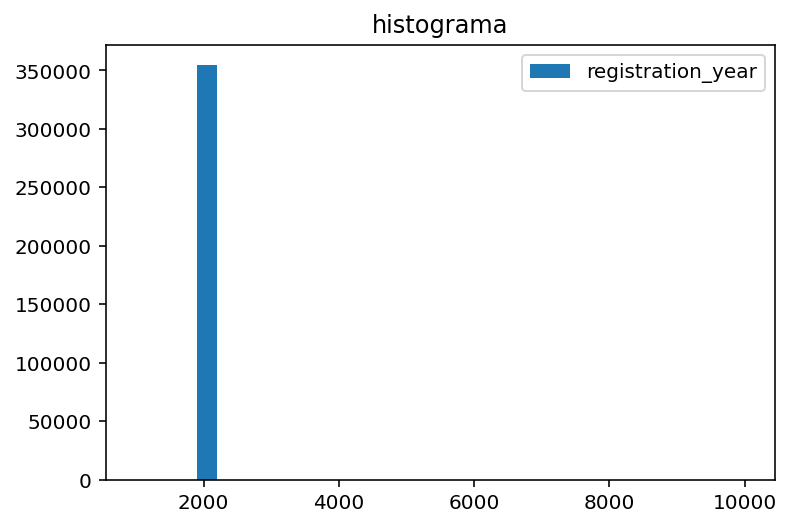

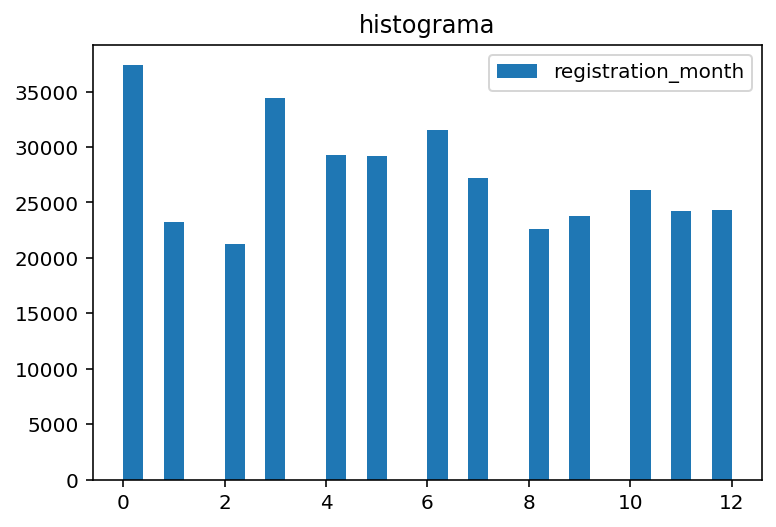

In [27]:
col_numerica = ["price", "power", "mileage", "registration_year", "registration_month"]
for i in col_numerica:
    plt.hist(data[i], bins=30, label=i)
    plt.legend(loc="upper right")
    plt.title("histograma")
    plt.show()

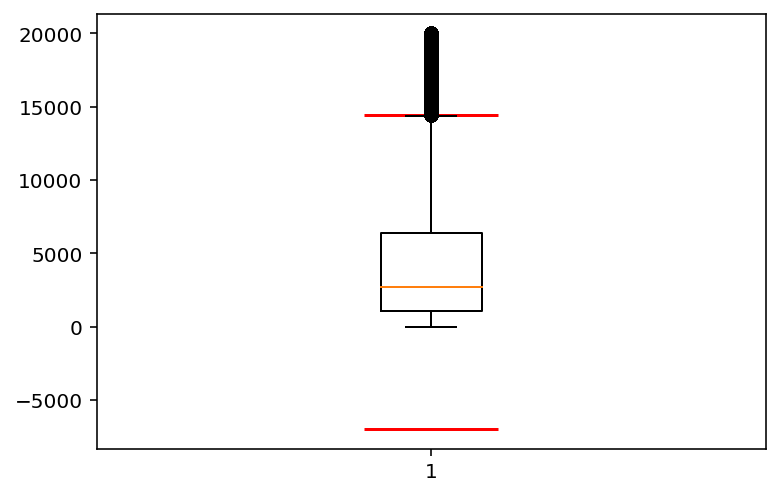

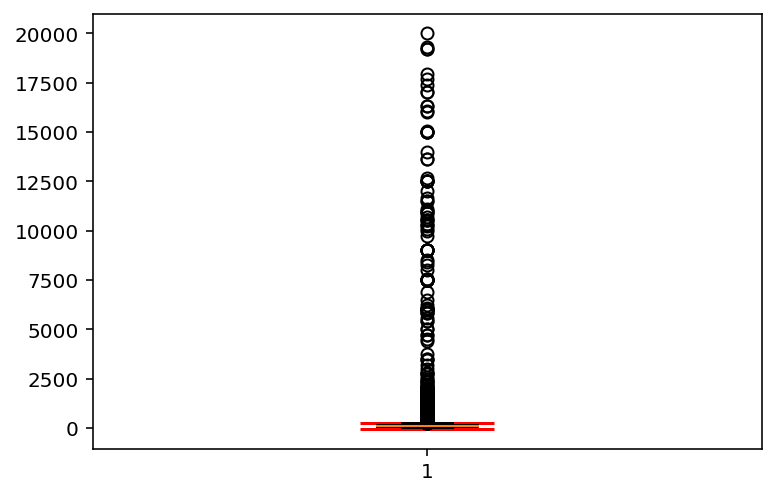

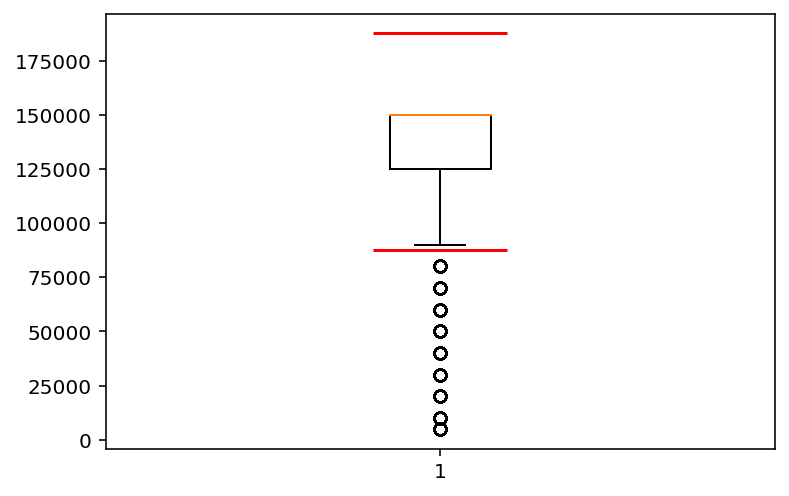

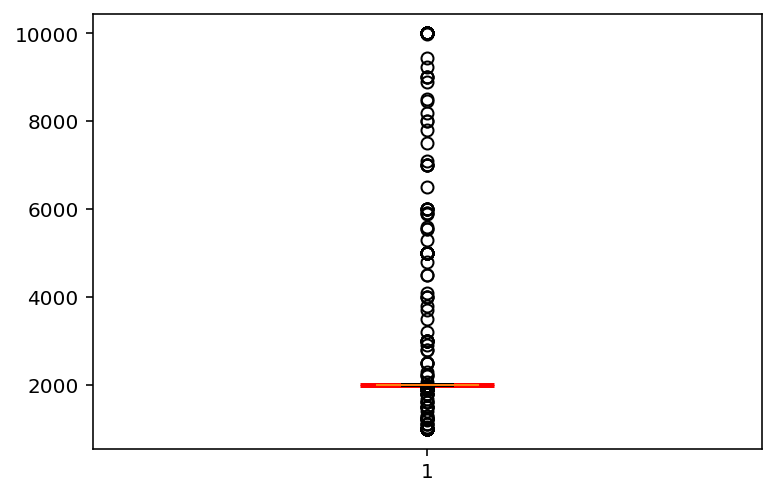

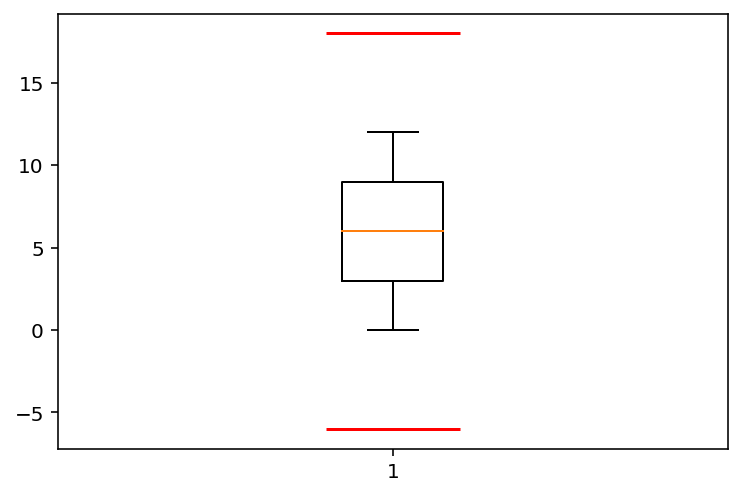

In [28]:
for i in col_numerica:
    plt.boxplot(data[i])
    Q1_inf = data[i].quantile(0.25)
    Q3_sup = data[i].quantile(0.75) 
    QR = Q3_sup - Q1_inf
    Q1 = Q1_inf - 1.5*QR
    Q3 = Q3_sup + 1.5*QR
    plt.hlines(y=[Q1,Q3], xmin = 0.9, xmax = 1.1, color = 'red')
    plt.show()

In [29]:
data["registration_month"].value_counts(normalize=True)

0     0.105404
3     0.096998
6     0.088913
4     0.082598
5     0.082267
7     0.076793
10    0.073649
12    0.068542
11    0.068251
9     0.067198
1     0.065522
8     0.063852
2     0.060014
Name: registration_month, dtype: float64

De los histogramas y boxplot:
1. La columna "precio" muestra una asimetría positiva (la media muy por encima de la mediana) con una larga cola a la derecha, la mayor concentración de datos se observa entre 0 y 6500 con datos atípicos por encima de los 15000.
2. La característica "power" muestra concentración de datos menor a 1000 y muchos valores atípicos por encima de este valor.
3. La columna "mileage" muestra una asimetría negativa con media por debajo de la mediana y cola a la izquierda, con datos atípicos por debajo de 80000 km.
4. La columna "registration_year" concentra la mayor cantidad de datos alrededor del 2000 sin embargo hay una gran cantidad de valores atípicos que se aprecian en el resumen estadístico con un año mínimo de 1000 y máximo de 9999.
5. La columna "registration_month" muestra un comportamiento bastante regular y discreto alrededor de cada mes del año, con la excepción de la alta frecuencia de datos en 0.
6. La columna "number_of_picture" tiene 0 en todos los registros, es decir, no hay fotos, por lo que esta columna será eliminada posteriormente, al igual que el código postal.

In [30]:
#analizando las columnas numericas
data.drop(data.query('price <= 1 or price > 15000').index, inplace=True)
data.reset_index(drop=True, inplace =True)

In [31]:
data.drop(data.query('power <= 0 or power > 2500').index, inplace=True)
data.reset_index(drop=True, inplace =True)

In [32]:
data.drop(data.query('registration_year < 1900 or registration_year > 2021').index, inplace=True)
data.reset_index(drop=True, inplace =True)

In [33]:
corr_matrix=data.corr(method="pearson")
corr_matrix

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
price,1.000000,0.412311,0.372296,-0.335617,0.076519,NaN,0.055572
registration_year,0.412311,1.000000,0.063708,-0.220486,0.024330,NaN,0.015032
power,0.372296,0.063708,1.000000,0.118916,0.032513,NaN,0.035632
mileage,-0.335617,-0.220486,0.118916,1.000000,-0.013638,NaN,-0.003209
registration_month,0.076519,0.024330,0.032513,-0.013638,1.000000,NaN,0.002371
number_of_pictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postal_code,0.055572,0.015032,0.035632,-0.003209,0.002371,NaN,1.000000


De acuerdo a la matriz de correlación:

1. El precio(target) mantiene una fuerte relación positiva con la potencia y año de registro, esto es consistente con que a mayor potencia del motor mayor será su precio y mientras más nuevo sea el coche será también más costoso.

2. Se observa una relación negativa con el km del vehículo, tal como era de esperarse, ya que a mayor kilometraje menor será el precio del vehículo.

3. Con las características "number_of_pictures", "registration_month" y "postal_code" no se alcanza a observar una relación considerable con el precio y particularmente para la columna "number_of_pictures" su valor se mantiene en NaN por lo que esta columna se descarta para el modelo.

4. Para continuar con el modelado, se procederá a eliminar también las columnas que no aportarán mayor valor al modelo como lo son: "date_crawled", "date_created", "lastseen".

In [34]:
data = data.drop(["date_crawled", "date_created", "last_seen", "number_of_pictures", "postal_code", "registration_month"], axis=1)

In [35]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
0,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,sin especificar
1,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
2,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
3,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
4,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


In [36]:
data=data.drop_duplicates().reset_index(drop=True)

In [37]:
data.duplicated().sum()

0

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253489 entries, 0 to 253488
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              253489 non-null  int64 
 1   vehicle_type       253489 non-null  object
 2   registration_year  253489 non-null  int64 
 3   gearbox            253489 non-null  object
 4   power              253489 non-null  int64 
 5   model              253489 non-null  object
 6   mileage            253489 non-null  int64 
 7   fuel_type          253489 non-null  object
 8   brand              253489 non-null  object
 9   not_repaired       253489 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.3+ MB


## Entrenamiento del modelo 

### Codificación de variables categóricas por Ordinal Encoder

Se realiza porque hay variables categóricas que en los algoritmos de regresion lineal, árbol de decisión y bosque no pueden utilizarse sino han sido convertidas a variables numéricas.
Para los algoritmos de LGBM y CatBooster no se requiere esta codificación.

In [39]:
#Codificación de variables categóricas

categoricas_columns = data[["vehicle_type", "gearbox", "model", "fuel_type", "brand", "not_repaired"]]
numericas_columns = data[["registration_year", "power", "mileage"]]
oe = OrdinalEncoder()
data_ordinal = pd.DataFrame(oe.fit_transform(categoricas_columns), columns=categoricas_columns.columns)
data_ordinal[["registration_year", "power", "mileage"]] = numericas_columns
data_ordinal["price"] = data["price"]
data_ordinal.head()

,vehicle_type,gearbox,model,fuel_type,brand,not_repaired,registration_year,power,mileage,price
0,6.0,0.0,117.0,2.0,14.0,1.0,2004,163,125000,9800
1,5.0,1.0,116.0,6.0,38.0,0.0,2001,75,150000,1500
2,5.0,1.0,101.0,2.0,31.0,0.0,2008,69,90000,3600
3,4.0,1.0,11.0,6.0,2.0,2.0,1995,102,150000,650
4,1.0,1.0,8.0,6.0,25.0,0.0,2004,109,150000,2200


### Escalado de las variables

En esta sección se procederá a realizar el escalado de las características, dado que sus valores difieren considerablemente.

In [40]:
# escalado
data_ordinal_scaled = pd.DataFrame(oe.fit_transform(categoricas_columns), columns = categoricas_columns.columns)
data_ordinal_scaled[["registration_year", "power", "mileage"]] = numericas_columns

scaler = StandardScaler()
data_ordinal_scaled =pd.DataFrame(scaler.fit_transform(data_ordinal_scaled), columns = data_ordinal_scaled.columns)
data_ordinal_scaled["price"] = data["price"]
data_ordinal_scaled

,vehicle_type,gearbox,model,fuel_type,brand,not_repaired,registration_year,power,mileage,price
0,0.891234,-1.949317,0.060137,-1.562850,-0.510954,0.920903,0.129155,0.675452,-0.119229,9800
1,0.407220,0.386865,0.046198,0.694586,1.304575,-0.569376,-0.300819,-0.672491,0.577494,1500
2,0.407220,0.386865,-0.162886,-1.562850,0.775046,-0.569376,0.702453,-0.764396,-1.094641,3600
3,-0.076794,0.386865,-1.417392,0.694586,-1.418718,2.411183,-1.160765,-0.258917,0.577494,650
4,-1.528837,0.386865,-1.459208,0.694586,0.321163,-0.569376,0.129155,-0.151695,0.577494,2200
...,...,...,...,...,...,...,...,...,...,...
253484,-0.560809,-1.949317,-1.514964,0.130227,-1.570012,-0.569376,1.849048,0.476324,0.577494,5250
253485,-0.076794,0.386865,0.380732,0.694586,0.699399,2.411183,0.129155,1.625140,0.577494,3200
253486,-1.528837,-1.949317,-0.093192,0.694586,0.850693,-0.569376,-0.444143,-0.274235,-0.119229,1199
253487,-2.012851,0.386865,1.551604,-1.562850,1.304575,-0.569376,-1.017441,-0.258917,0.577494,9200


### Features y target

Se hace el split de la data en entrenamiento, validación y test.

In [41]:
#selección de features y target
features = data_ordinal_scaled.drop("price", axis=1)
target = data_ordinal_scaled["price"]


In [79]:
#separación de muestras
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target,  test_size = 0.40, random_state = 12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

In [43]:
features_train.shape, features_valid.shape, features_test.shape, target_train.shape, target_valid.shape, target_test.shape

((152093, 9), (50698, 9), (50698, 9), (152093,), (50698,), (50698,))

### Defición de funciones para RMSE y modelo

Se definen las funciones con la que se realizarán los cálculos de la métrica de evaluación RMSE y el entranamiento y ajuste del modelo.

In [44]:
#funcion para el cálculo de RMSE
def rmse(target, predict):
    return (mean_squared_error(target, predict)) ** 0.5

r_scorer = make_scorer(rmse, greater_is_better=False)

In [81]:
def modelo(model, x_train, y_train, x_valid, y_valid, hiperparametros={}, scoring=None, cv=5, verbose=False):
    np.random.seed(42)
    best_rmse = 0
    start_time = time.time()
    #afinamiento de hiperparámetros
    gridsearch = GridSearchCV(model, param_grid=hiperparametros, scoring=scoring, cv=cv)
    gridsearch.fit(x_train, y_train)
    #ajuste del modelo con los mejores hiperparámetros
    gridsearch.best_estimator_.fit(x_train, y_train)
    #predicción
    prediccion = gridsearch.best_estimator_.predict(x_valid)
    best_rmse = rmse(y_valid, prediccion)
    end_time = time.time() - start_time
    return gridsearch.best_estimator_, best_rmse, np.round(end_time, 2)

### Modelo de regresión lineal

In [82]:
#Regresion lineal

lr = LinearRegression()
%time lr_model, lr_rmse, lr_tiempo = modelo(lr, features_train, target_train, features_valid, target_valid, hiperparametros={}, scoring=r_scorer, cv=5)
print("RMSE para", lr_model, ":", lr_rmse, "tiempo de ejecución:", lr_tiempo)

CPU times: user 301 ms, sys: 605 ms, total: 906 ms
Wall time: 870 ms
RMSE para LinearRegression() : 2743.3670942111144 tiempo de ejecución: 0.87


### Modelo Random Forest Regressor

In [83]:
#Random forest regressor

rf = RandomForestRegressor(random_state=42)
%time forest_model, forest_rmse, forest_tiempo = modelo(rf, features_train, target_train, features_valid, target_valid, hiperparametros={"n_estimators": [30, 40, 50], "max_depth": [40, 50]}, scoring=r_scorer, cv=5)
print("RMSE para", forest_model, ":", forest_rmse, "tiempo de ejecución:", forest_tiempo)

CPU times: user 10min 31s, sys: 4.73 s, total: 10min 36s
Wall time: 10min 38s
RMSE para RandomForestRegressor(max_depth=40, n_estimators=50, random_state=42) : 1488.2367553830998 tiempo de ejecución: 638.61


### Modelo Decision Tree Regressor

In [84]:
#Decision Tree

dt = DecisionTreeRegressor(random_state=42)
hiperparametros_dt = {"max_depth" : list(np.arange(1,40,1)),"min_samples_split": range(2, 10, 2)}
%time decision_model, decision_rmse, decision_tiempo = modelo(dt, features_train, target_train, features_valid, target_valid, hiperparametros=hiperparametros_dt, scoring=r_scorer, cv=5)
print("RMSE para", decision_model, ":", decision_rmse, "tiempo de ejecución:", decision_tiempo)


CPU times: user 6min 12s, sys: 202 ms, total: 6min 13s
Wall time: 6min 16s
RMSE para DecisionTreeRegressor(max_depth=14, min_samples_split=8, random_state=42) : 1655.8486892384183 tiempo de ejecución: 376.59


### Modelo  LGBM

Se realiza la selección de features y target de la data original.

In [85]:
#LGBM Regressor
#Para aplicar este algoritmo se debe usar la data sin etiquetado
data_lgbm = data
for col in cat_features:
    data_lgbm[col] = data_lgbm[col].astype("category")

features_lgbm = data_lgbm.drop("price", axis=1)
target_lgbm = data_lgbm["price"]

#split
features_train_lgbm, features_valid_lgbm, target_train_lgbm, target_valid_lgbm = train_test_split(
    features_lgbm, target_lgbm,  test_size = 0.40, random_state = 12345)

features_valid_lgbm, features_test_lgbm, target_valid_lgbm, target_test_lgbm = train_test_split(
    features_valid_lgbm, target_valid_lgbm, test_size=0.5, random_state=12345)

lgbm = LGBMRegressor(random_state=42)
hiper_lgbm = {"learning_rate": [0.1, 0.5], "max_depth": [5, 7, 10], "n_estimators": [500, 1000], "num_leaves": [20, 40]}


%time lgbm_model, lgbm_rmse, lgbm_tiempo = modelo(lgbm,features_train_lgbm, target_train_lgbm, features_valid_lgbm, target_valid_lgbm, hiperparametros=hiper_lgbm, scoring=r_scorer, cv=3 )
print("RMSE para", lgbm_model, ":", lgbm_rmse, "tiempo de ejecución:", lgbm_tiempo)

CPU times: user 19min 8s, sys: 5.83 s, total: 19min 14s
Wall time: 19min 23s
RMSE para LGBMRegressor(max_depth=10, n_estimators=1000, num_leaves=40, random_state=42) : 1378.5347416411357 tiempo de ejecución: 1163.1


### Modelo Cat Boost Regressor

Para este modelo, se seleccionan las features de la data original sin clasificación, ya que este modelo puede trabajar con las variables categóricas.

In [86]:
# Catboost regressor
#definición de target y features sin escalmiento ni clasificación
cat_features = ["vehicle_type", "gearbox", "model", "fuel_type", "brand", "not_repaired"]
features_catb = data.drop("price", axis=1)
target_catb = data["price"]

#split
features_train_catb, features_valid_catb, target_train_catb, target_valid_catb = train_test_split(
    features_catb, target_catb,  test_size = 0.40, random_state = 12345)

features_valid_catb, features_test_catb, target_valid_catb, target_test_catb = train_test_split(
    features_valid_catb, target_valid_catb, test_size=0.5, random_state=12345)

#definiendo el modelo
cat = CatBoostRegressor(loss_function = "RMSE", cat_features = cat_features, random_state = 42)
#hiperparámetros
hiper_cat = {"iterations": [30, 50, 100], "max_depth" : [8, 10, 12], "learning_rate": [0.01, 0.5]}
start_time = time.time()
gridsearch_catb = GridSearchCV(estimator = cat, param_grid=hiper_cat, scoring=r_scorer, cv=3, verbose=10, n_jobs = -1)
gridsearch_catb.fit(features_train_catb, target_train_catb)

model_catb = CatBoostRegressor(**gridsearch_catb.best_params_)
model_catb.fit(features_train_catb, target_train_catb, cat_features=cat_features, eval_set=(features_valid_catb, target_valid_catb), verbose=False, plot=False) # train the model 
# predicciones
prediccion_catb = model_catb.predict(features_valid_catb)
rmse_catb = rmse(target_valid_catb, prediccion_catb)
end_time = time.time() - start_time
tiempo_ejecucion_catb = np.round(end_time, 2)

print("RMSE para CatBoostRegressor" ":", rmse_catb, "tiempo de ejecución:", tiempo_ejecucion_catb)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3; 1/18] START iterations=30, learning_rate=0.01, max_depth=8.............
0:	learn: 3700.6801676	total: 121ms	remaining: 3.51s
1:	learn: 3676.5889239	total: 242ms	remaining: 3.38s
2:	learn: 3652.7807972	total: 356ms	remaining: 3.21s
3:	learn: 3629.2432573	total: 487ms	remaining: 3.17s
4:	learn: 3606.0881950	total: 617ms	remaining: 3.09s
5:	learn: 3583.3542664	total: 734ms	remaining: 2.94s
6:	learn: 3561.0005493	total: 850ms	remaining: 2.79s
7:	learn: 3538.8298245	total: 969ms	remaining: 2.67s
8:	learn: 3517.1508202	total: 1.08s	remaining: 2.53s
9:	learn: 3495.2451728	total: 1.2s	remaining: 2.41s
10:	learn: 3473.5815922	total: 1.32s	remaining: 2.29s
11:	learn: 3452.4365701	total: 1.45s	remaining: 2.17s
12:	learn: 3431.5808222	total: 1.56s	remaining: 2.05s
13:	learn: 3411.2888035	total: 1.67s	remaining: 1.91s
14:	learn: 3390.2982360	total: 1.78s	remaining: 1.78s
15:	learn: 3370.1133696	total: 1.9s	remaining: 1.67s
16:	le

In [87]:
print(gridsearch_catb.best_params_)

{'iterations': 100, 'learning_rate': 0.5, 'max_depth': 10}


1. El modelo de LGBM es el que mejor se ajusta (RMSE= 1378) aunque toma más tiempo para el ajuste de sus hiperparámetros (19 min).
2. seguido de Catboost con 10 min y RMSE de 1435.
3. El modelo de regresión lineal el de menor ajuste (RMSE = 2743) aunque en tiempo menor a 1 min. 
4. Los modelos de Random Forest y Decision Tree se toman más tiempo para el ajuste de sus hiperparámetros y sus RMSE son un poco más altas (1488 y 1655 respectivamente) a las obtenidas con los algoritmos Boosting.

## Análisis del modelo

In [89]:
resultados = pd.DataFrame({'model': ["LinearRegression", "RandomForestRegressor",  "DecisionTreeRegressor","LGBM", "CatBoostRegressor"],
              'best_rmse': [lr_rmse, forest_rmse, decision_rmse, lgbm_rmse, rmse_catb]})
resultados

,model,best_rmse
0,LinearRegression,2743.367094
1,RandomForestRegressor,1488.236755
2,DecisionTreeRegressor,1655.848689
3,LGBM,1378.534742
4,CatBoostRegressor,1435.377273


De los 5 modelos analizados se observa que el menor RMSE se obtiene con el modelo de LGBM y el mayor RMSE con el modelo de regresion Lineal.

In [103]:
lr_test = LinearRegression()
#ajuste
start_time_fit_lr = time.time()
lr_test.fit(features_train, target_train)
end_time_fit_lr = time.time() - start_time_fit_lr

#prediccion
start_time_pred_lr = time.time()
prediccion_test_lr = lr_test.predict(features_test)
metric_lr = (mean_squared_error(target_test, prediccion_test_lr)) ** 0.5
end_time_pred_lr = time.time() - start_time_pred_lr

In [104]:
rf_test = RandomForestRegressor(max_depth=50, n_estimators=40,random_state=42)
#ajuste
start_time_fit_rf = time.time()
rf_test.fit(features_train, target_train)
end_time_fit_rf = time.time() - start_time_fit_rf

#prediccion
start_time_pred_rf = time.time()
prediccion_test_rf = rf_test.predict(features_test)
metric_rf = (mean_squared_error(target_test, prediccion_test_rf)) ** 0.5
end_time_pred_rf = time.time() - start_time_pred_rf


In [105]:
dt_test = DecisionTreeRegressor(max_depth=14, min_samples_split=8,random_state=42)
#ajuste
start_time_fit_dt = time.time()
dt_test.fit(features_train, target_train)
end_time_fit_dt = time.time() - start_time_fit_dt

#prediccion
start_time_pred_dt = time.time()
prediccion_test_dt = dt_test.predict(features_test)
metric_dt = (mean_squared_error(target_test, prediccion_test_dt)) ** 0.5
end_time_pred_dt = time.time() - start_time_pred_dt


In [106]:
lgbm_test = LGBMRegressor(learning_rate= 0.5, n_estimators = 1000, max_depth=10, num_leaves=40,random_state=42)
#ajuste
start_time_fit_lgbm = time.time()
lgbm_test.fit(features_train_lgbm, target_train_lgbm)
end_time_fit_lgbm = time.time() - start_time_fit_lgbm

#prediccion
start_time_pred_lgbm = time.time()
prediccion_test_lgbm = lgbm_test.predict(features_test_lgbm)
metric_lgbm = (mean_squared_error(target_test_lgbm, prediccion_test_lgbm)) ** 0.5
end_time_pred_lgbm = time.time() - start_time_pred_lgbm


In [107]:
catb_test = CatBoostRegressor(loss_function = "RMSE", cat_features = cat_features, learning_rate= 0.5, iterations = 100, max_depth=10, random_state = 42)
#ajuste
start_time_fit_catb = time.time()
catb_test.fit(features_train_catb, target_train_catb)
end_time_fit_catb = time.time() - start_time_fit_catb

#prediccion
start_time_pred_catb = time.time()
prediccion_test_catb = catb_test.predict(features_test_catb)
metric_catb = (mean_squared_error(target_test_catb, prediccion_test_catb)) ** 0.5
end_time_pred_catb = time.time() - start_time_pred_catb


0:	learn: 2597.6126212	total: 247ms	remaining: 24.5s
1:	learn: 2115.1604860	total: 510ms	remaining: 25s
2:	learn: 1877.6563391	total: 736ms	remaining: 23.8s
3:	learn: 1754.6615047	total: 975ms	remaining: 23.4s
4:	learn: 1676.9582537	total: 1.21s	remaining: 23s
5:	learn: 1631.3009641	total: 1.43s	remaining: 22.4s
6:	learn: 1604.0239053	total: 1.66s	remaining: 22.1s
7:	learn: 1583.7460302	total: 1.9s	remaining: 21.9s
8:	learn: 1565.3513968	total: 2.14s	remaining: 21.6s
9:	learn: 1550.2257976	total: 2.37s	remaining: 21.4s
10:	learn: 1532.5398563	total: 2.61s	remaining: 21.1s
11:	learn: 1521.0633362	total: 2.84s	remaining: 20.8s
12:	learn: 1513.0482229	total: 3.08s	remaining: 20.6s
13:	learn: 1504.5175504	total: 3.32s	remaining: 20.4s
14:	learn: 1498.8340036	total: 3.55s	remaining: 20.1s
15:	learn: 1492.1283185	total: 3.79s	remaining: 19.9s
16:	learn: 1483.7228945	total: 4.02s	remaining: 19.6s
17:	learn: 1476.4409774	total: 4.24s	remaining: 19.3s
18:	learn: 1472.2207837	total: 4.47s	remain

In [109]:
resultados_1 = pd.DataFrame({"model": ["LinearRegression", "RandomForestRegressor",  "DecisionTreeRegressor","LGBM", "CatBoostRegressor"],
              "best_rmse_test_data": [metric_lr, metric_rf, metric_dt, metric_lgbm, metric_catb], 
              "best_rmse_valid_data": [lr_rmse, forest_rmse, decision_rmse, lgbm_rmse, rmse_catb],               
              "tiempo de ajuste(s)":[end_time_fit_lr,end_time_fit_rf, end_time_fit_dt, end_time_fit_lgbm, end_time_fit_catb],
              "tiempo_prediccion(s)":[end_time_pred_lr, end_time_pred_rf, end_time_pred_dt, end_time_pred_lgbm, end_time_pred_catb]})
resultados_1

,model,best_rmse_test_data,best_rmse_valid_data,tiempo de ajuste(s),tiempo_prediccion(s)
0,LinearRegression,2777.567665,2743.367094,0.029275,0.002858
1,RandomForestRegressor,1511.343586,1488.236755,19.267622,0.820405
2,DecisionTreeRegressor,1683.036392,1655.848689,0.475904,0.013362
3,LGBM,1459.835190,1378.534742,20.994732,5.109159
4,CatBoostRegressor,1455.759286,1435.377273,23.714032,0.063395


Finalmente se observa que para el conjunto de datos separados como "test" los modelos Boosting (CatBoost y LGBM) arrojan los menores valores de RMSE (al igual que en la data de validación) aunque emplean más tiempo en el ajuste del modelo. El modelo de regresión lineal es el que menos se ajusta aunque sus tiempos son mínimos.

## Conclusion

Se concluye:

1. La data original constaba de 16 columnas y 354369 registros.
2. Se encontraron 5 columnas con datos ausentes (vehicleType, Gearbox, Model, Fuel_type, NotRepaired)
3. El nombre de las columnas estan en mayúsculas y sin separadores.
4. 262 datos duplicados
5. Se eliminaron las columnas que no aportan al modelo de machine learning.
6. Se etiquetaron las características categóricas y escalaron.
6. El modelo LGBM y CatBoost fueron los que menores RMSE reportaron tanto para el conjunto de datos de validación como de prueba con tiempos altos de ajuste de hiperparámetros y de predicción.
7. El modelo de Regresión lineal es el que mayor RMSE arrojó con tiempos bajos de ejecución.

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores- [ ]  Las celdas con el código han sido colocadas en orden de ejecución- [ ]  Los datos han sido descargados y preparados- [ ]  Los modelos han sido entrenados
- [ ]  Se realizó el análisis de velocidad y calidad de los modelos